In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import files
uploaded = files.upload()


Saving Data_bank_additional_balanced (1).csv to Data_bank_additional_balanced (1).csv


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Διαβάστε τα δεδομένα, εφαρμόστε όποια στάδια προεργασίας θεωρείτε απαραίτητα σύμφωνα
με τη δομή των δεδομένων, και χωρίστε το dataset σε 70% training 15% validation και 15%
test δείγματα με τυχαίο τρόπο. Στη συνέχεια να εκπαιδευτεί νευρωνικό δίκτυο 2 επιπέδων για
την ταξινόμηση των δειγμάτων, όπου το 1ο
layer θα έχει 32 νευρώνες με συνάρτηση
ενεργοποίησης sigmoid, χρησιμοποιώντας Stochastic Gradient Descend και 100 εποχές
εκπαίδευσης.

In [5]:
data = pd.read_csv("Data_bank_additional_balanced (1).csv")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=58282)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=58282)

print("Train positives:", y_train.sum())
print("Val positives:", y_val.sum())
print("Test positives:", y_test.sum())

Train positives: 323
Val positives: 67
Test positives: 61


In [6]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label


In [7]:
batch_size = 64

train_loader = DataLoader(CustomDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(CustomDataset(X_val, y_val),   batch_size=batch_size)
test_loader  = DataLoader(CustomDataset(X_test, y_test), batch_size=batch_size)


In [33]:
input_dim = X_train.shape[1]  # πρέπει να είναι 11

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 2)  # 2 κλάσεις

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)      # 1ο layer με sigmoid, όπως ζητάει η εκφώνηση
        x = self.fc2(x)       # logits για τις 2 κλάσεις
        return x

model = Net()
print(model)


Net(
  (fc1): Linear(in_features=11, out_features=32, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # Υπολογισμός val accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}  Val Acc: {val_acc:.4f}")


Epoch [1/100] Train Loss: 0.7137  Val Acc: 0.3704
Epoch [10/100] Train Loss: 0.6776  Val Acc: 0.6667
Epoch [20/100] Train Loss: 0.6450  Val Acc: 0.7704
Epoch [30/100] Train Loss: 0.6149  Val Acc: 0.8222
Epoch [40/100] Train Loss: 0.5877  Val Acc: 0.8074
Epoch [50/100] Train Loss: 0.5625  Val Acc: 0.7926
Epoch [60/100] Train Loss: 0.5397  Val Acc: 0.7926
Epoch [70/100] Train Loss: 0.5194  Val Acc: 0.8000
Epoch [80/100] Train Loss: 0.5015  Val Acc: 0.8000
Epoch [90/100] Train Loss: 0.4856  Val Acc: 0.8000
Epoch [100/100] Train Loss: 0.4716  Val Acc: 0.8000


In [35]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7721


In [36]:
import torch.nn.functional as F

model.eval()
all_probs = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        probs = F.softmax(outputs, dim=1)[:, 1]  # πιθανότητα για κλάση 1
        all_probs.extend(probs.cpu().numpy())

# all_probs περιέχει την πιθανότητα επιτυχίας για κάθε τηλεφωνική κλήση στο test set


Να αποτυπωθεί η εξέλιξη του validation accuracy μετά από κάθε epoch εκπαίδευσης σε
διάγραμμα, και να υπολογιστεί ο πίνακας σύγχυσης του τελικού μοντέλου για το test set

Epoch 1
-------------------------------
loss: 0.702300  [   64/  630]
loss: 0.696722  [  128/  630]
loss: 0.704854  [  192/  630]
loss: 0.690346  [  256/  630]
loss: 0.686845  [  320/  630]
loss: 0.675252  [  384/  630]
loss: 0.696630  [  448/  630]
loss: 0.680671  [  512/  630]
loss: 0.692581  [  576/  630]
loss: 0.685725  [  630/  630]
Validation Error: 
 Accuracy: 48.1%, Avg loss: 0.686363 

Epoch 2
-------------------------------
loss: 0.678787  [   64/  630]
loss: 0.699336  [  128/  630]
loss: 0.670260  [  192/  630]
loss: 0.694230  [  256/  630]
loss: 0.690252  [  320/  630]
loss: 0.693561  [  384/  630]
loss: 0.686567  [  448/  630]
loss: 0.687824  [  512/  630]
loss: 0.696088  [  576/  630]
loss: 0.685747  [  630/  630]
Validation Error: 
 Accuracy: 54.8%, Avg loss: 0.683918 

Epoch 3
-------------------------------
loss: 0.686538  [   64/  630]
loss: 0.685600  [  128/  630]
loss: 0.681717  [  192/  630]
loss: 0.691171  [  256/  630]
loss: 0.680060  [  320/  630]
loss: 0.689378

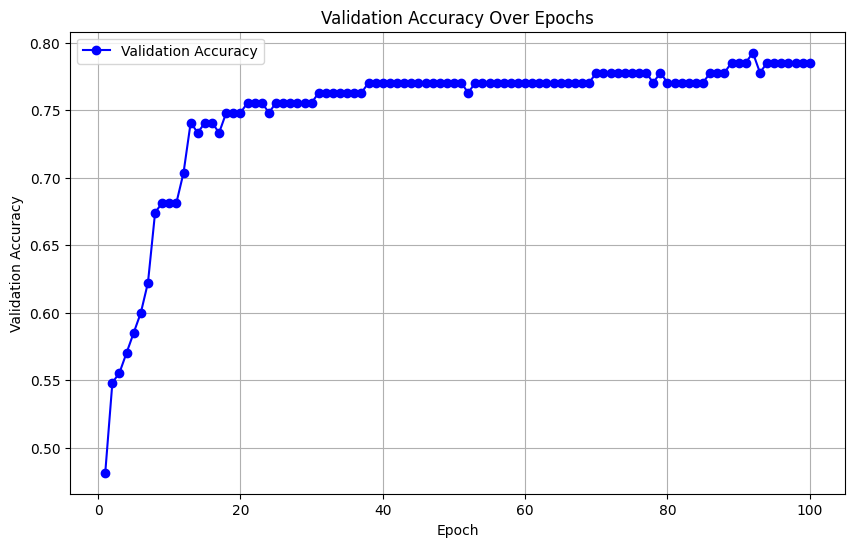

Test accuracy: 77.2%



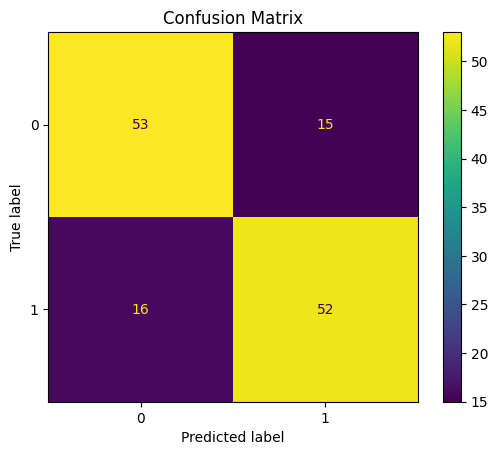

In [37]:
learning_rate = 1e-2

modelS = NeuralNetwork(nn.Sigmoid())

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(modelS.parameters(), lr=learning_rate)
epochs = 100
val_acc = np.empty(100)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, modelS, loss_fn, optimizer)
    val_acc[t] = val_loop(val_loader, modelS, loss_fn)
print("Done!")

# Plotting the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_acc, marker='o', linestyle='-', color='b', label='Validation Accuracy')

# Adding labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

y_predS = test(test_loader, modelS)
ConfusionMatrixDisplay.from_predictions(y_test, y_predS)
plt.title("Confusion Matrix")
plt.show()


Epoch 1
-------------------------------
loss: 0.678366  [   64/  630]
loss: 0.684661  [  128/  630]
loss: 0.676375  [  192/  630]
loss: 0.679451  [  256/  630]
loss: 0.603795  [  320/  630]
loss: 0.573138  [  384/  630]
loss: 0.620656  [  448/  630]
loss: 0.556612  [  512/  630]
loss: 0.529360  [  576/  630]
loss: 0.552436  [  630/  630]
Validation Error: 
 Accuracy: 77.8%, Avg loss: 0.517428 

Epoch 2
-------------------------------
loss: 0.531054  [   64/  630]
loss: 0.501659  [  128/  630]
loss: 0.574362  [  192/  630]
loss: 0.539835  [  256/  630]
loss: 0.481732  [  320/  630]
loss: 0.507934  [  384/  630]
loss: 0.496359  [  448/  630]
loss: 0.515431  [  512/  630]
loss: 0.498401  [  576/  630]
loss: 0.423641  [  630/  630]
Validation Error: 
 Accuracy: 78.5%, Avg loss: 0.449022 

Epoch 3
-------------------------------
loss: 0.552146  [   64/  630]
loss: 0.477506  [  128/  630]
loss: 0.433438  [  192/  630]
loss: 0.352325  [  256/  630]
loss: 0.452223  [  320/  630]
loss: 0.418673

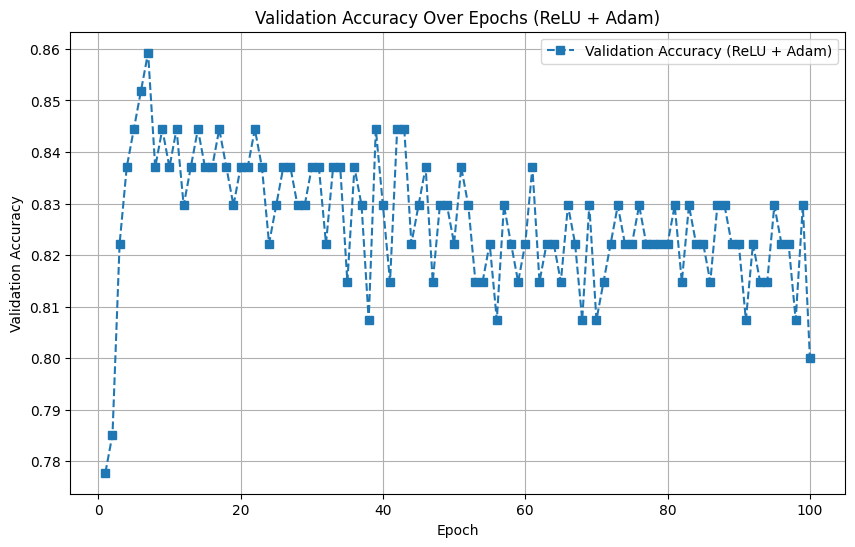

Test accuracy: 83.1%



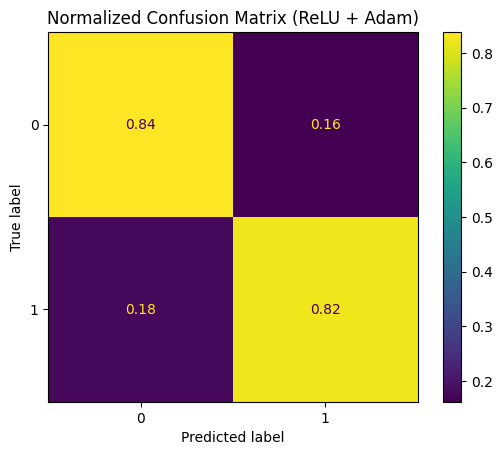

In [38]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Διαφορετικό μοντέλο: ReLU αντί για Sigmoid
learning_rate = 5e-3   # λίγο μικρότερο lr, γιατί ο Adam είναι πιο "επιθετικός"

modelR = NeuralNetwork(nn.ReLU())  # νέο μοντέλο με ReLU

loss_fn = nn.CrossEntropyLoss()

# 2. Διαφορετικός optimizer: Adam αντί για SGD
optimizer = torch.optim.Adam(modelR.parameters(), lr=learning_rate)

epochs = 100
val_acc_R = np.empty(epochs)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Υποθέτω ότι το train_loop ΔΕΝ επιστρέφει κάτι (ίδιο όπως πριν)
    train_loop(train_loader, modelR, loss_fn, optimizer)
    val_acc_R[t] = val_loop(val_loader, modelR, loss_fn)

print("Done (ReLU + Adam)!")

# 3. Plot validation accuracy για το νέο setup
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, epochs + 1),
    val_acc_R,
    marker='s',
    linestyle='--',
    label='Validation Accuracy (ReLU + Adam)'
)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs (ReLU + Adam)')
plt.grid(True)
plt.legend()
plt.show()

# 4. Test set & normalized confusion matrix
y_predR = test(test_loader, modelR)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_predR,
    normalize='true'      # κανονικοποιημένο ως προς το πραγματικό class
)
plt.title("Normalized Confusion Matrix (ReLU + Adam)")
plt.show()


Epoch 1
-------------------------------
loss: 0.669832  [   64/  630]
loss: 0.658828  [  128/  630]
loss: 0.656347  [  192/  630]
loss: 0.663485  [  256/  630]
loss: 0.663532  [  320/  630]
loss: 0.632951  [  384/  630]
loss: 0.638853  [  448/  630]
loss: 0.644836  [  512/  630]
loss: 0.649864  [  576/  630]
loss: 0.631761  [  630/  630]
Validation Error: 
 Accuracy: 66.7%, Avg loss: 0.631619 

Epoch 2
-------------------------------
loss: 0.636865  [   64/  630]
loss: 0.645591  [  128/  630]
loss: 0.646329  [  192/  630]
loss: 0.638361  [  256/  630]
loss: 0.634452  [  320/  630]
loss: 0.637540  [  384/  630]
loss: 0.653451  [  448/  630]
loss: 0.634189  [  512/  630]
loss: 0.653288  [  576/  630]
loss: 0.637524  [  630/  630]
Validation Error: 
 Accuracy: 71.9%, Avg loss: 0.620447 

Epoch 3
-------------------------------
loss: 0.656932  [   64/  630]
loss: 0.622498  [  128/  630]
loss: 0.610352  [  192/  630]
loss: 0.640393  [  256/  630]
loss: 0.600440  [  320/  630]
loss: 0.637541

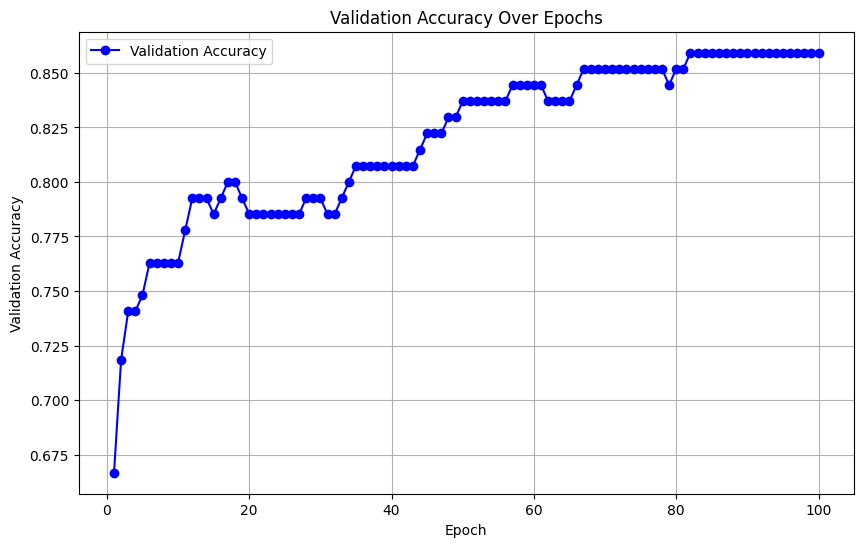

Test accuracy: 82.4%



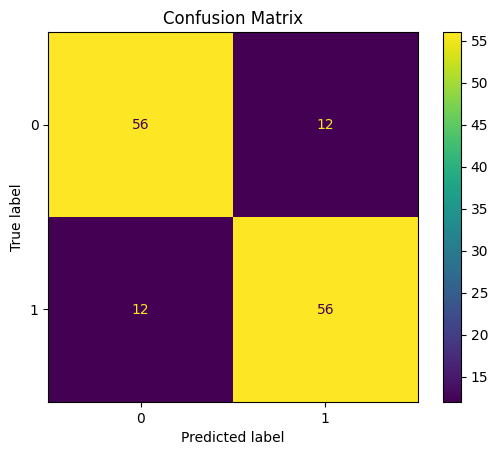

In [39]:
learning_rate = 1e-2

modelR = NeuralNetwork(nn.ReLU())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelR.parameters(), lr=learning_rate)

epochs = 100
val_acc = np.empty(epochs)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, modelR, loss_fn, optimizer)
    val_acc[t] = val_loop(val_loader, modelR, loss_fn)

print("Done!")

# Plotting the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_acc, marker='o', linestyle='-', color='b', label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

y_predR = test(test_loader, modelR)
ConfusionMatrixDisplay.from_predictions(y_test, y_predR)
plt.title("Confusion Matrix")
plt.show()


Γ

Να επαναληφθεί η εκπαίδευση με συνάρτηση ενεργοποίησης την ReLU. Τί παρατηρείτε?

Με την επανάληψη της εκπαίδευσης με συνάρτηση ενεργοποίησης ReLU αντί για Sigmoid παρατηρείται σαφής βελτίωση της απόδοσης του μοντέλου. Η καμπύλη της validation accuracy αυξάνεται ταχύτερα και φτάνει σε υψηλότερη τελική τιμή (0.86 έναντι 0.79), ενώ μειώνεται και το loss τόσο στο training όσο και στο validation set. Οι Confusion Matrices δείχνουν μείωση των λανθασμένων ταξινομήσεων από 31 σε 24 και πιο ισορροπημένη συμπεριφορά μεταξύ των δύο κλάσεων, γεγονός που υποδηλώνει καλύτερη γενίκευση.
Η βελτίωση αυτή είναι αναμενόμενη, καθώς η ReLU έχει παράγωγο ίση με 1 για θετικές τιμές της εισόδου (και 0 για μη θετικές), ενώ η Sigmoid έχει παράγωγο που εξαρτάται από την τιμή της και είναι πάντοτε μικρότερη ή ίση του 0.25. Κατά το backpropagation, ο πολλαπλασιασμός αυτών των παραγώγων (chain rule) στη Sigmoid οδηγεί σε σταδιακή μείωση του gradient στα πρώιμα layers (vanishing gradient), ενώ στη ReLU το gradient παραμένει ισχυρό για τις ενεργές μονάδες (x>0), επιτρέποντας ταχύτερη εκμάθηση και πιο σαφή διαχωρισμό των κλάσεων.

Δ

Πειραματιστείτε με τις παραμέτρους σχεδίασης, και προτείνετε ένα δίκτυο που επιτυγχάνει
καλύτερη ακρίβεια από τα προηγούμενα. Τεκμηριώστε το αποτέλεσμα με τα απαραίτητα
γραφήματα και πίνακες σύγχυσης

In [42]:
class BetterNet(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(BetterNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)   # logits
        )

    def forward(self, x):
        return self.net(x)


Epoch 1
-------------------------------
loss: 0.704681  [   64/  630]
loss: 0.679744  [  128/  630]
loss: 0.676128  [  192/  630]
loss: 0.686427  [  256/  630]
loss: 0.669083  [  320/  630]
loss: 0.662083  [  384/  630]
loss: 0.660635  [  448/  630]
loss: 0.651510  [  512/  630]
loss: 0.642396  [  576/  630]
loss: 0.638026  [  630/  630]
Validation Error: 
 Accuracy: 80.7%, Avg loss: 0.630966 

Epoch 2
-------------------------------
loss: 0.637565  [   64/  630]
loss: 0.653512  [  128/  630]
loss: 0.625159  [  192/  630]
loss: 0.608137  [  256/  630]
loss: 0.616087  [  320/  630]
loss: 0.598219  [  384/  630]
loss: 0.610739  [  448/  630]
loss: 0.560810  [  512/  630]
loss: 0.605785  [  576/  630]
loss: 0.576566  [  630/  630]
Validation Error: 
 Accuracy: 77.8%, Avg loss: 0.567421 

Epoch 3
-------------------------------
loss: 0.624820  [   64/  630]
loss: 0.531270  [  128/  630]
loss: 0.569556  [  192/  630]
loss: 0.542400  [  256/  630]
loss: 0.560325  [  320/  630]
loss: 0.578751

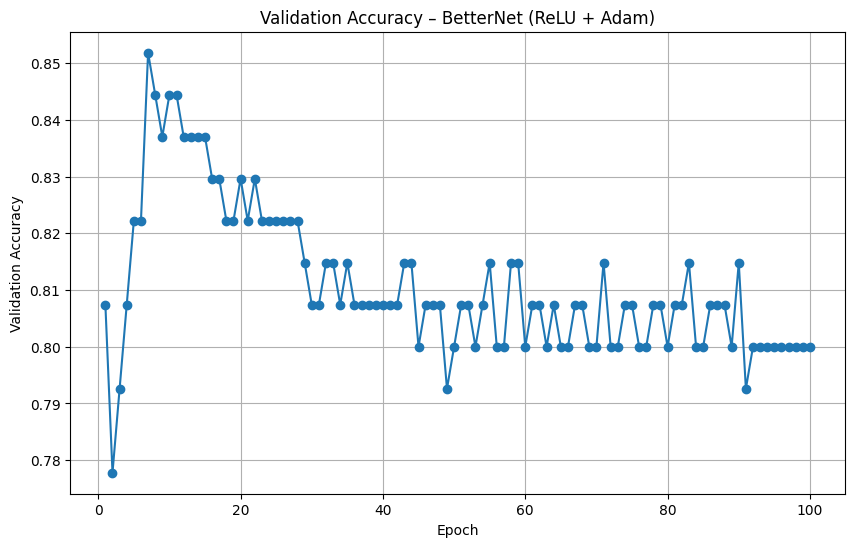

Test accuracy: 82.4%



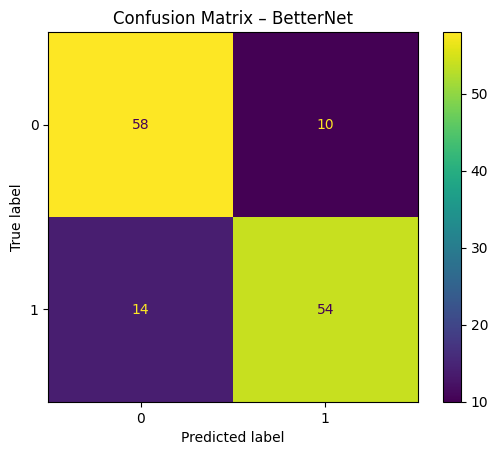

In [44]:
learning_rate = 1e-3
epochs = 100

modelB = BetterNet(input_dim=input_dim, num_classes=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelB.parameters(), lr=learning_rate)

val_acc = np.empty(epochs)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, modelB, loss_fn, optimizer)
    val_acc[t] = val_loop(val_loader, modelB, loss_fn)

print("Done!")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), val_acc, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy – BetterNet (ReLU + Adam)')
plt.grid(True)
plt.show()

y_predB = test(test_loader, modelB)
ConfusionMatrixDisplay.from_predictions(y_test, y_predB)
plt.title("Confusion Matrix – BetterNet")
plt.show()


In [49]:

class NeuralNetworkMod(nn.Module):
    def __init__(self):
        super(NeuralNetworkMod, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(11, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Dropout(p=0.1),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits


Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
----------------

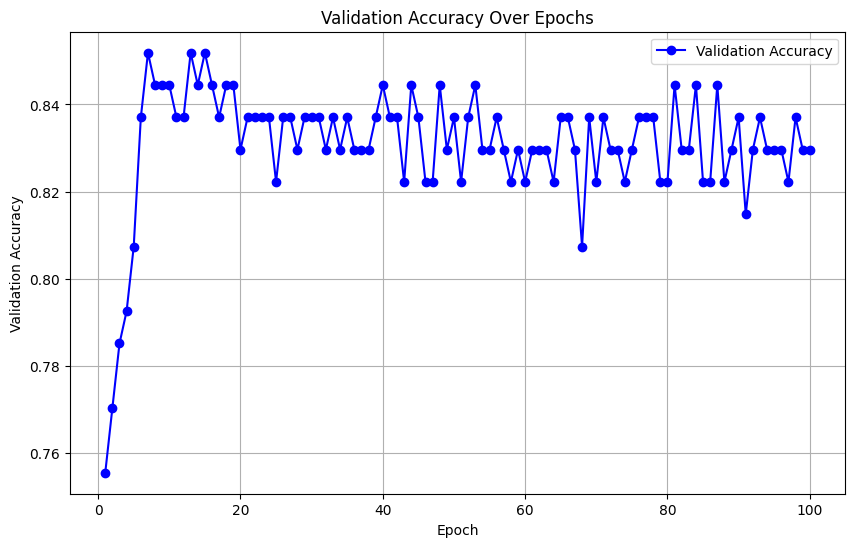

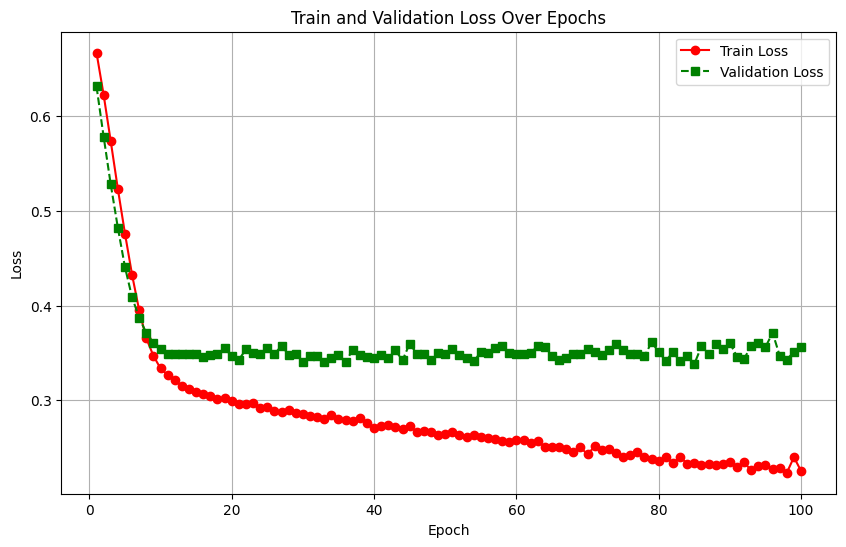

Test accuracy: 84.6%



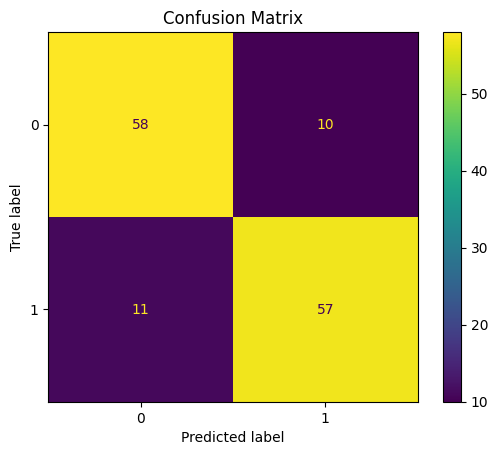

In [51]:
model = NeuralNetworkMod()
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 100
train_losses = np.empty(epochs)
train_accuracies = np.empty(epochs)
val_losses = np.empty(epochs)
val_accuracies = np.empty(epochs)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_epoch, train_acc_epoch = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss_epoch, val_acc_epoch = val_loop(val_loader, model, loss_fn)

    train_losses[t] = train_loss_epoch
    train_accuracies[t] = train_acc_epoch
    val_losses[t] = val_loss_epoch
    val_accuracies[t] = val_acc_epoch

print("Done!")

# Plotting the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Plotting train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='r', label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='s', linestyle='--', color='g', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

y_predM = test(test_loader, model)
ConfusionMatrixDisplay.from_predictions(y_test, y_predM)
plt.title("Confusion Matrix")
plt.show()

In [52]:
#3περιπτωση
class BetterNet(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(BetterNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)    # logits
        )

    def forward(self, x):
        return self.net(x)


In [53]:
input_dim = X_train.shape[1]


In [55]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# -----------------------------
# train_loop: επιστρέφει (loss, accuracy)
# -----------------------------
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0.0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # forward
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # στατιστικά
        running_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # ενδεικτική εκτύπωση ανά batch (προαιρετικά)
        if (batch + 1) * X.size(0) % 64 == 0 or (batch == len(dataloader) - 1):
            current = (batch + 1) * X.size(0)
            print(f"loss: {loss.item():>8f}  [ {current:>4}/{size:>4}]")

    epoch_loss = running_loss / size
    epoch_acc = correct / size
    print(f"Train Epoch: Avg loss: {epoch_loss:>8f}, Accuracy: {epoch_acc:>0.4f}\n")
    return epoch_loss, epoch_acc


# -----------------------------
# val_loop: επιστρέφει (loss, accuracy)
# -----------------------------
def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)

            running_loss += loss.item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_loss = running_loss / size
    epoch_acc = correct / size
    print(f"Validation: Avg loss: {epoch_loss:>8f}, Accuracy: {epoch_acc:>0.4f}\n")
    return epoch_loss, epoch_acc


Epoch 1
-------------------------------
loss: 0.725433  [   64/ 630]
loss: 0.718551  [  128/ 630]
loss: 0.743954  [  192/ 630]
loss: 0.732715  [  256/ 630]
loss: 0.693021  [  320/ 630]
loss: 0.726972  [  384/ 630]
loss: 0.714527  [  448/ 630]
loss: 0.721791  [  512/ 630]
loss: 0.721030  [  576/ 630]
loss: 0.710155  [  540/ 630]
Train Epoch: Avg loss: 0.720984, Accuracy: 0.3968

Validation: Avg loss: 0.712822, Accuracy: 0.4370

Epoch 2
-------------------------------
loss: 0.728448  [   64/ 630]
loss: 0.704900  [  128/ 630]
loss: 0.707608  [  192/ 630]
loss: 0.702550  [  256/ 630]
loss: 0.700649  [  320/ 630]
loss: 0.690227  [  384/ 630]
loss: 0.712980  [  448/ 630]
loss: 0.702476  [  512/ 630]
loss: 0.716168  [  576/ 630]
loss: 0.689013  [  540/ 630]
Train Epoch: Avg loss: 0.705764, Accuracy: 0.4381

Validation: Avg loss: 0.697541, Accuracy: 0.4889

Epoch 3
-------------------------------
loss: 0.709450  [   64/ 630]
loss: 0.710531  [  128/ 630]
loss: 0.690769  [  192/ 630]
loss: 0.697

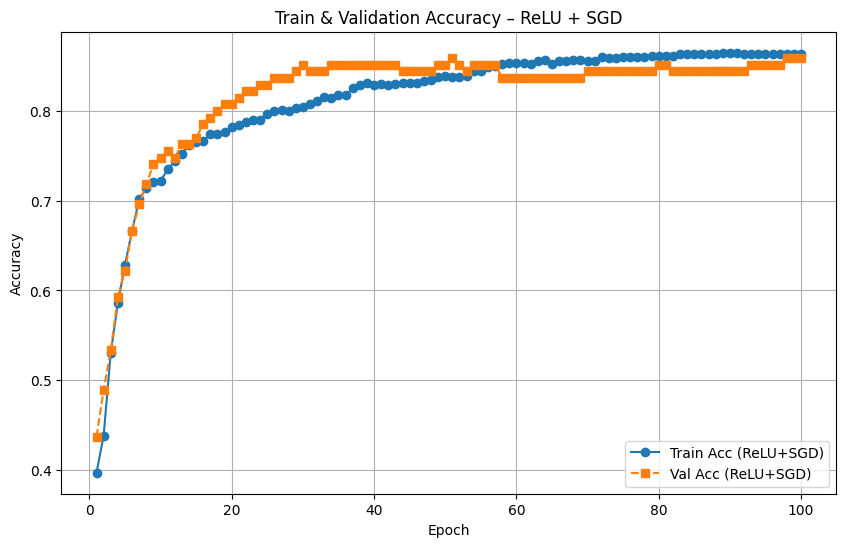

Test accuracy: 80.9%



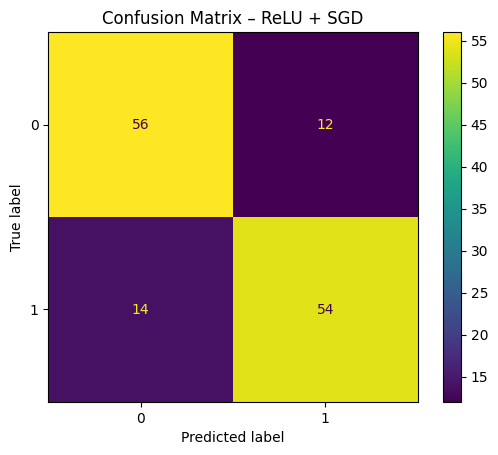

In [56]:
loss_fn = nn.CrossEntropyLoss()

learning_rate_sgd = 1e-2
epochs = 100

model_relu_sgd = NeuralNetwork(nn.ReLU())
optimizer_relu_sgd = torch.optim.SGD(model_relu_sgd.parameters(), lr=learning_rate_sgd)

train_loss_relu_sgd = np.empty(epochs)
val_loss_relu_sgd   = np.empty(epochs)
train_acc_relu_sgd  = np.empty(epochs)
val_acc_relu_sgd    = np.empty(epochs)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_loss, tr_acc = train_loop(train_loader, model_relu_sgd, loss_fn, optimizer_relu_sgd)
    va_loss, va_acc = val_loop(val_loader,   model_relu_sgd, loss_fn)

    train_loss_relu_sgd[t] = tr_loss
    val_loss_relu_sgd[t]   = va_loss
    train_acc_relu_sgd[t]  = tr_acc
    val_acc_relu_sgd[t]    = va_acc

print("Done (ReLU + SGD)!")


# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_acc_relu_sgd, marker='o', linestyle='-', label='Train Acc (ReLU+SGD)')
plt.plot(range(1, epochs+1), val_acc_relu_sgd,   marker='s', linestyle='--', label='Val Acc (ReLU+SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy – ReLU + SGD')
plt.grid(True)
plt.legend()
plt.show()

# Confusion matrix στο test set
y_pred_relu_sgd = test(test_loader, model_relu_sgd)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_relu_sgd)
plt.title("Confusion Matrix – ReLU + SGD")
plt.show()


Epoch 1
-------------------------------
loss: 0.669212  [   64/ 630]
loss: 0.700309  [  128/ 630]
loss: 0.651396  [  192/ 630]
loss: 0.687323  [  256/ 630]
loss: 0.702150  [  320/ 630]
loss: 0.696127  [  384/ 630]
loss: 0.666590  [  448/ 630]
loss: 0.645952  [  512/ 630]
loss: 0.671998  [  576/ 630]
loss: 0.634920  [  540/ 630]
Train Epoch: Avg loss: 0.673196, Accuracy: 0.5651

Validation: Avg loss: 0.651021, Accuracy: 0.6074

Epoch 2
-------------------------------
loss: 0.629536  [   64/ 630]
loss: 0.618824  [  128/ 630]
loss: 0.655971  [  192/ 630]
loss: 0.617457  [  256/ 630]
loss: 0.640792  [  320/ 630]
loss: 0.629985  [  384/ 630]
loss: 0.604551  [  448/ 630]
loss: 0.615108  [  512/ 630]
loss: 0.617957  [  576/ 630]
loss: 0.626332  [  540/ 630]
Train Epoch: Avg loss: 0.625641, Accuracy: 0.6825

Validation: Avg loss: 0.608507, Accuracy: 0.7037

Epoch 3
-------------------------------
loss: 0.648529  [   64/ 630]
loss: 0.619327  [  128/ 630]
loss: 0.614784  [  192/ 630]
loss: 0.581

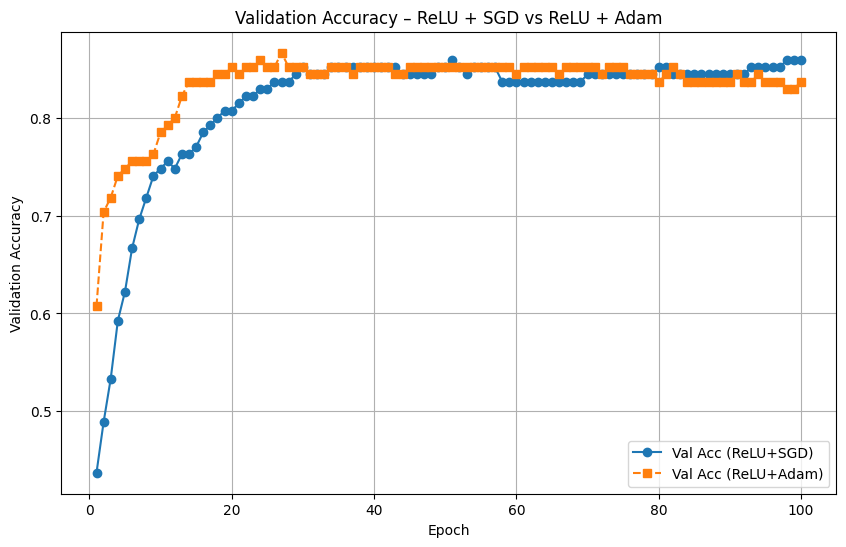

Test accuracy: 84.6%



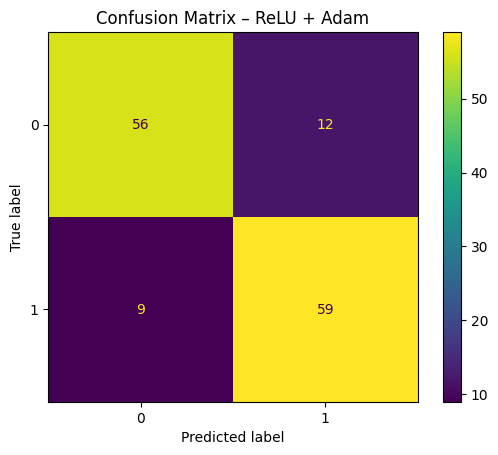

In [57]:
#Περίπτωση Β: 1 hidden layer, ReLU + Adam
learning_rate_adam = 1e-3
epochs = 100

model_relu_adam = NeuralNetwork(nn.ReLU())
optimizer_relu_adam = torch.optim.Adam(model_relu_adam.parameters(), lr=learning_rate_adam)

train_loss_relu_adam = np.empty(epochs)
val_loss_relu_adam   = np.empty(epochs)
train_acc_relu_adam  = np.empty(epochs)
val_acc_relu_adam    = np.empty(epochs)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_loss, tr_acc = train_loop(train_loader, model_relu_adam, loss_fn, optimizer_relu_adam)
    va_loss, va_acc = val_loop(val_loader,   model_relu_adam, loss_fn)

    train_loss_relu_adam[t] = tr_loss
    val_loss_relu_adam[t]   = va_loss
    train_acc_relu_adam[t]  = tr_acc
    val_acc_relu_adam[t]    = va_acc

print("Done (ReLU + Adam)!")


# Plot accuracy (σύγκριση με ReLU+SGD)
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), val_acc_relu_sgd,   marker='o', linestyle='-',  label='Val Acc (ReLU+SGD)')
plt.plot(range(1, epochs+1), val_acc_relu_adam,  marker='s', linestyle='--', label='Val Acc (ReLU+Adam)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy – ReLU + SGD vs ReLU + Adam')
plt.grid(True)
plt.legend()
plt.show()

# Confusion matrix στο test set
y_pred_relu_adam = test(test_loader, model_relu_adam)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_relu_adam)
plt.title("Confusion Matrix – ReLU + Adam")
plt.show()


In [58]:
#Περίπτωση Γ: Δύο κρυφά layers (BetterNet) + ReLU + Adam
class BetterNet(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(BetterNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)   # logits
        )

    def forward(self, x):
        return self.net(x)


Epoch 1
-------------------------------
loss: 0.679771  [   64/ 630]
loss: 0.681185  [  128/ 630]
loss: 0.659903  [  192/ 630]
loss: 0.675749  [  256/ 630]
loss: 0.650222  [  320/ 630]
loss: 0.653719  [  384/ 630]
loss: 0.632622  [  448/ 630]
loss: 0.614656  [  512/ 630]
loss: 0.626074  [  576/ 630]
loss: 0.614726  [  540/ 630]
Train Epoch: Avg loss: 0.649404, Accuracy: 0.7540

Validation: Avg loss: 0.610450, Accuracy: 0.8370

Epoch 2
-------------------------------
loss: 0.613852  [   64/ 630]
loss: 0.617548  [  128/ 630]
loss: 0.593270  [  192/ 630]
loss: 0.582509  [  256/ 630]
loss: 0.570095  [  320/ 630]
loss: 0.584453  [  384/ 630]
loss: 0.594727  [  448/ 630]
loss: 0.555484  [  512/ 630]
loss: 0.528730  [  576/ 630]
loss: 0.607968  [  540/ 630]
Train Epoch: Avg loss: 0.584497, Accuracy: 0.8048

Validation: Avg loss: 0.538978, Accuracy: 0.7926

Epoch 3
-------------------------------
loss: 0.527922  [   64/ 630]
loss: 0.525302  [  128/ 630]
loss: 0.525132  [  192/ 630]
loss: 0.532

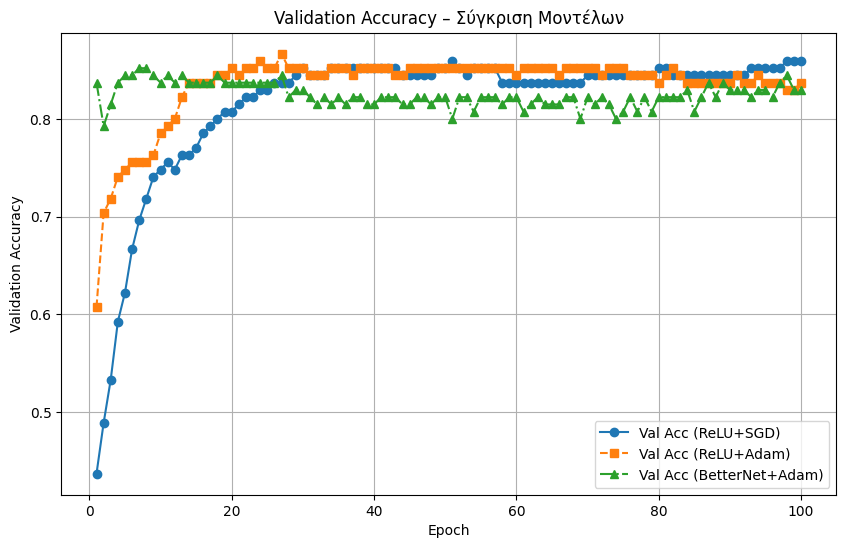

Test accuracy: 85.3%



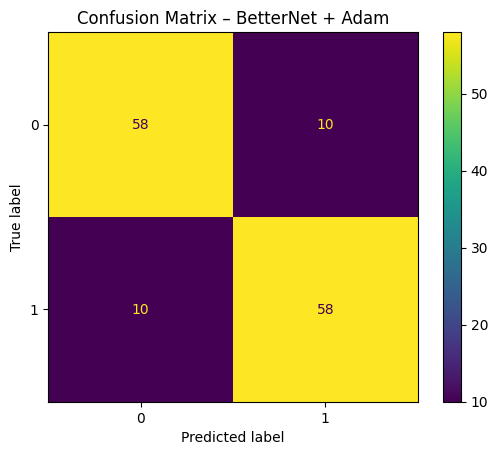

In [59]:
input_dim = X_train.shape[1]
learning_rate_better = 1e-3
epochs = 100

model_better = BetterNet(input_dim=input_dim, num_classes=2)
optimizer_better = torch.optim.Adam(model_better.parameters(), lr=learning_rate_better)

train_loss_better = np.empty(epochs)
val_loss_better   = np.empty(epochs)
train_acc_better  = np.empty(epochs)
val_acc_better    = np.empty(epochs)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_loss, tr_acc = train_loop(train_loader, model_better, loss_fn, optimizer_better)
    va_loss, va_acc = val_loop(val_loader,   model_better, loss_fn)

    train_loss_better[t] = tr_loss
    val_loss_better[t]   = va_loss
    train_acc_better[t]  = tr_acc
    val_acc_better[t]    = va_acc

print("Done (BetterNet + Adam)!")


# Plot validation accuracy σύγκρισης όλων
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), val_acc_relu_sgd,   marker='o', linestyle='-',  label='Val Acc (ReLU+SGD)')
plt.plot(range(1, epochs+1), val_acc_relu_adam,  marker='s', linestyle='--', label='Val Acc (ReLU+Adam)')
plt.plot(range(1, epochs+1), val_acc_better,     marker='^', linestyle='-.', label='Val Acc (BetterNet+Adam)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy – Σύγκριση Μοντέλων')
plt.grid(True)
plt.legend()
plt.show()

# Confusion matrix BetterNet στο test set
y_pred_better = test(test_loader, model_better)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_better)
plt.title("Confusion Matrix – BetterNet + Adam")
plt.show()


Πειραματιστηκά με τρεις διαφορετικές παραμετροποιήσεις του MLP, κρατώντας σταθερό το dataset και τη διαδικασία εκπαίδευσης:

1.Μοντέλο Α – ReLU + SGD (1 κρυφό layer)

2.Μοντέλο Β – ReLU + Adam (1 κρυφό layer)

3.Μοντέλο Γ – BetterNet + Adam (2 κρυφά layers, 64 και 32 νευρώνες)

Για κάθε μοντέλο καταγράφθηκε η εξέλιξη της validation accuracy ανά epoch και υπολογίσθηκέ  τον πίνακα σύγχυσης στο test set.

Από τα διαγράμματα validation accuracy προκύπτει ότι και τα τρία μοντέλα συγκλίνουν σε παρόμοια επίπεδα επίδοσης, με τα μοντέλα με Adam (Β και Γ) να φτάνουν γρηγορότερα σε υψηλή ακρίβεια σε σχέση με το απλό μοντέλο με SGD. Το Μοντέλο Α (ReLU+SGD) ξεκινά από χαμηλότερες τιμές και συγκλίνει πιο αργά, ενώ τα Μοντέλα Β και Γ παρουσιάζουν ταχύτερη αύξηση της accuracy στα πρώτα epochs λόγω του adaptive βήματος μάθησης του Adam.

Η αξιολόγηση στο test set δείχνει:

->ReLU + SGD (Μοντέλο Α): test accuracy ≈ 80.9%, confusion matrix: 56 σωστές και 12 λανθασμένες ταξινομήσεις για την κλάση 0, 54 σωστές και 14 λανθασμένες για την κλάση 1 (συνολικά 26 λάθη).

->ReLU + Adam (Μοντέλο Β): test accuracy ≈ 84.6%, confusion matrix: 56 σωστές / 12 λανθασμένες για την κλάση 0 και 59 σωστές / 9 λανθασμένες για την κλάση 1 (21 λάθη).

->BetterNet + Adam (Μοντέλο Γ): test accuracy ≈ 85.3%, confusion matrix: 58 σωστές / 10 λανθασμένες για κάθε κλάση (σύνολο 20 λάθη).

Παρατηρούμε ότι η χρήση του Adam βελτιώνει σημαντικά τη γενίκευση σε σχέση με τον SGD, ενώ η αύξηση της χωρητικότητας του δικτύου (δύο κρυφά layers αντί για ένα) οδηγεί σε μικρή αλλά μετρήσιμη περαιτέρω βελτίωση στην απόδοση: το BetterNet + Adam εμφανίζει τη μεγαλύτερη test accuracy και τον πίνακα σύγχυσης με τις λιγότερες συνολικές λανθασμένες ταξινομήσεις και σχεδόν τέλεια ισορροπία μεταξύ των δύο κλάσεων.

Συμπέρασμα:
Ως προτεινόμενο τελικό δίκτυο επιλέγουμε το BetterNet με δύο κρυφά επίπεδα (64 και 32 νευρώνες), συνάρτηση ενεργοποίησης ReLU και optimizer Adam, καθώς επιτυγχάνει την υψηλότερη ακρίβεια στο test set (≈85.3%) και τον καλύτερο πίνακα σύγχυσης, δείχνοντας την καλύτερη ικανότητα γενίκευσης ανάμεσα στα εξεταζόμενα μοντέλα.

Ε

Υπολογίστε και αποτυπώστε τις καμπύλες precision-recall και ROC μεταβάλλοντας το
κατώφλι της πιθανότητας κάθε κλάσης, για το αρχικό μοντέλο και για το καλύτερο μοντέλο
που πέτυχατε στο βήμα Δ. Υπολογίστε το AUC (Area Under Curve) που προκύπτει από τις
καμπύλες.

Αρχικό μοντέλο → modelS (Sigmoid + SGD)

Καλύτερο μοντέλο → model_better (BetterNet + Adam)

In [60]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

def get_probs_and_labels(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            logits = model(X)                     # [batch, num_classes]
            probs  = torch.softmax(logits, dim=1) # μετατροπή σε πιθανότητες
            all_probs.append(probs[:, 1].cpu().numpy())   # πιθανότητα κλάσης 1
            all_labels.append(y.cpu().numpy())
    y_true  = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)
    return y_true, y_score


In [61]:
# Αρχικό μοντέλο (modelS – Sigmoid + SGD)
y_true_S, y_score_S = get_probs_and_labels(modelS, test_loader)

# Καλύτερο μοντέλο (BetterNet + Adam)
y_true_B, y_score_B = get_probs_and_labels(model_better, test_loader)
# (ιδανικά y_true_S και y_true_B είναι τα ίδια και ίσα με y_test)

# Precision–Recall
prec_S, rec_S, thr_pr_S = precision_recall_curve(y_true_S, y_score_S)
prec_B, rec_B, thr_pr_B = precision_recall_curve(y_true_B, y_score_B)

auc_pr_S = auc(rec_S, prec_S)
auc_pr_B = auc(rec_B, prec_B)

print(f"PR AUC (Αρχικό μοντέλο):  {auc_pr_S:.4f}")
print(f"PR AUC (BetterNet+Adam): {auc_pr_B:.4f}")

# ROC
fpr_S, tpr_S, thr_roc_S = roc_curve(y_true_S, y_score_S)
fpr_B, tpr_B, thr_roc_B = roc_curve(y_true_B, y_score_B)

auc_roc_S = auc(fpr_S, tpr_S)
auc_roc_B = auc(fpr_B, tpr_B)

print(f"ROC AUC (Αρχικό μοντέλο):  {auc_roc_S:.4f}")
print(f"ROC AUC (BetterNet+Adam): {auc_roc_B:.4f}")


PR AUC (Αρχικό μοντέλο):  0.8442
PR AUC (BetterNet+Adam): 0.8665
ROC AUC (Αρχικό μοντέλο):  0.8612
ROC AUC (BetterNet+Adam): 0.8997


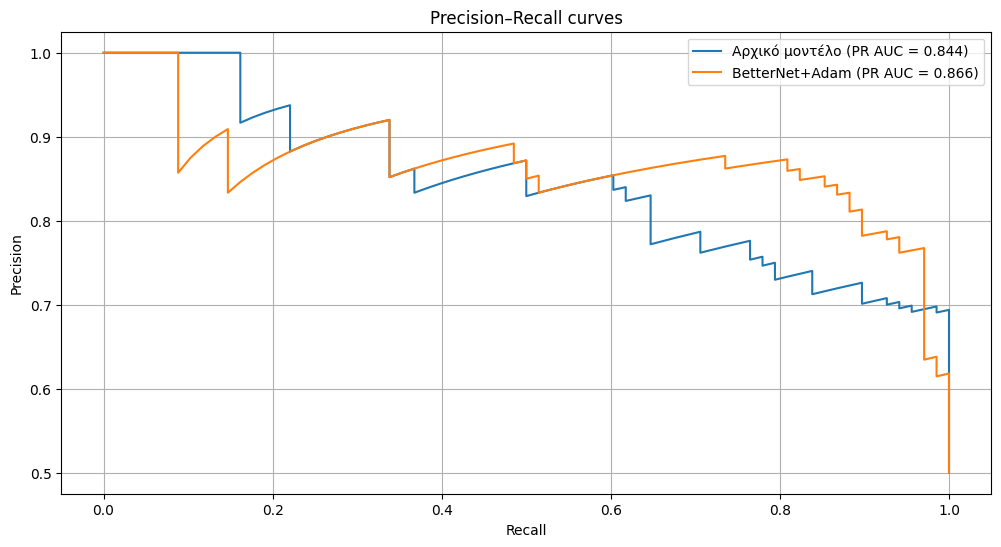

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(rec_S, prec_S, label=f'Αρχικό μοντέλο (PR AUC = {auc_pr_S:.3f})')
plt.plot(rec_B, prec_B, label=f'BetterNet+Adam (PR AUC = {auc_pr_B:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall curves')
plt.grid(True)
plt.legend()
plt.show()


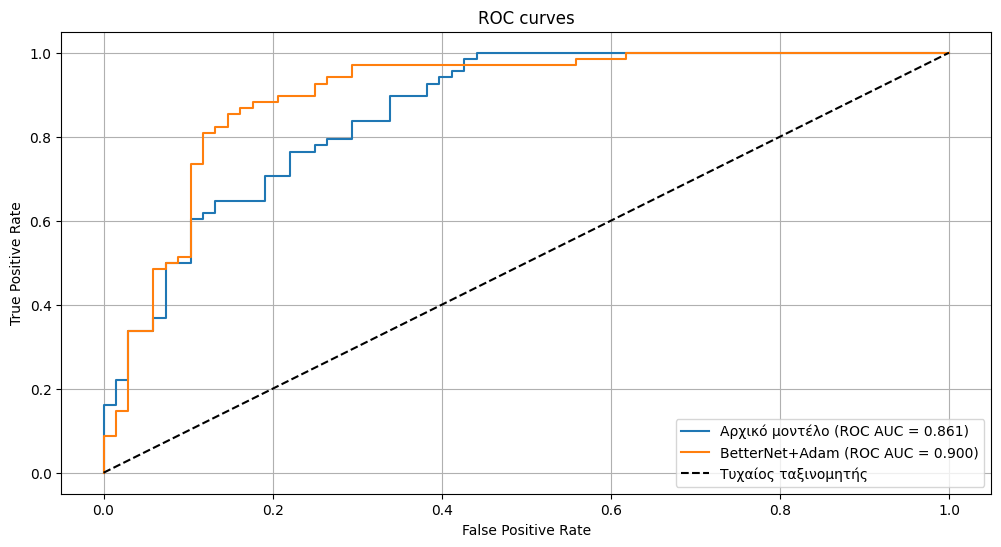

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(fpr_S, tpr_S, label=f'Αρχικό μοντέλο (ROC AUC = {auc_roc_S:.3f})')
plt.plot(fpr_B, tpr_B, label=f'BetterNet+Adam (ROC AUC = {auc_roc_B:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Τυχαίος ταξινομητής')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.grid(True)
plt.legend()
plt.show()


Υπολογισθηκάν  καμπύλες precision–recall και ROC για το αρχικό μοντέλο (MLP με Sigmoid) και για το καλύτερο μοντέλο που προέκυψε στο ερώτημα Δ (BetterNet με δύο κρυφά επίπεδα, ReLU και Adam).

Για κάθε μοντέλο χρησιμοποιήθηκαν οι προβλέψεις πιθανοτήτων στο test set και με τις συναρτήσεις precision_recall_curve και roc_curve της βιβλιοθήκης scikit-learn υπολογίστηκαν τα αντίστοιχα σημεία των καμπυλών, καθώς και το εμβαδόν κάτω από την καμπύλη (AUC) με τη συνάρτηση auc.

Από τις καμπύλες precision–recall προκύπτουν οι τιμές PR AUC = 0.844 για το αρχικό μοντέλο και PR AUC = 0.867 για το BetterNet+Adam. Αντίστοιχα, από τις καμπύλες ROC προκύπτουν ROC AUC = 0.861 για το αρχικό μοντέλο και ROC AUC = 0.900 για το BetterNet+Adam.

Παρατηρούμε ότι το καλύτερο μοντέλο  απο το ερώτημα Δ υπερέχει συστηματικά: η καμπύλη PR βρίσκεται  πάνω από την καμπύλη του αρχικού μοντέλου, ενώ στην ROC καμπύλη προσεγγίζει περισσότερο το ιδανικό σημείο (TPR→1, FPR→0) και απέχει περισσότερο από τη διαγώνιο του τυχαίου ταξινομητή (AUC=0.5). Συνεπώς, το BetterNet+Adam δεν βελτιώνει μόνο την accuracy σε ένα συγκεκριμένο κατώφλι, αλλά παρουσιάζει συνολικά καλύτερη συμπεριφορά ως ταξινομητής για όλα τα δυνατά thresholds, όπως αποτυπώνεται από τις υψηλότερες τιμές PR AUC και ROC AUC.